In [134]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sounddevice as sd
from scipy.io import wavfile
from scipy import signal
from pydub import AudioSegment

In [135]:
f = 'Ensoniq-ZR-76-03-Dope-85.wav'
samplerate, data = wavfile.read(f)
print('Sampling Rate:',samplerate)
print('Audio Shape:',np.shape(data))

duration = len(data)/samplerate
time = np.arange(0,duration,1/samplerate) #time vector
print(f"длительность {duration} \n временная шкала {time}")

type(data)

Sampling Rate: 44100
Audio Shape: (124443, 2)
длительность 2.8218367346938775 
 временная шкала [0.00000000e+00 2.26757370e-05 4.53514739e-05 ... 2.82176871e+00
 2.82179138e+00 2.82181406e+00]


/var/folders/k_/ygbwpkdn4dn6f0kwtbykqvz00000gn/T/ipykernel_1728/2326811316.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(f)


numpy.ndarray

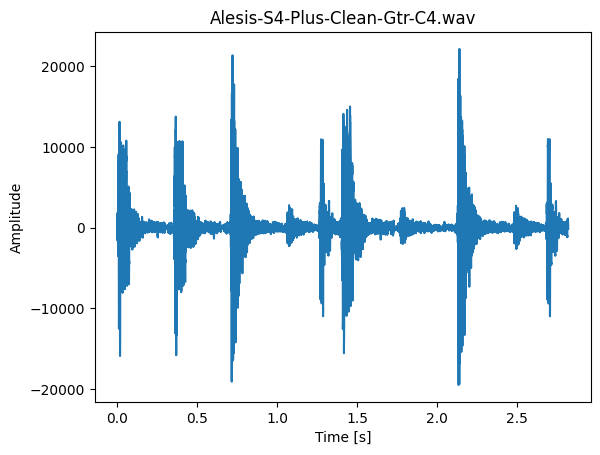

In [136]:
plt.plot(time, data[:, 0])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Alesis-S4-Plus-Clean-Gtr-C4.wav')
plt.show()

In [137]:
# слушаем, что получилось
sd.play(data[:, 0], samplerate)
sd.wait()

Sampling Rate: 44100
Audio Shape: (124443,)


/var/folders/k_/ygbwpkdn4dn6f0kwtbykqvz00000gn/T/ipykernel_1728/327378838.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(t,a,'k-',color='purple')


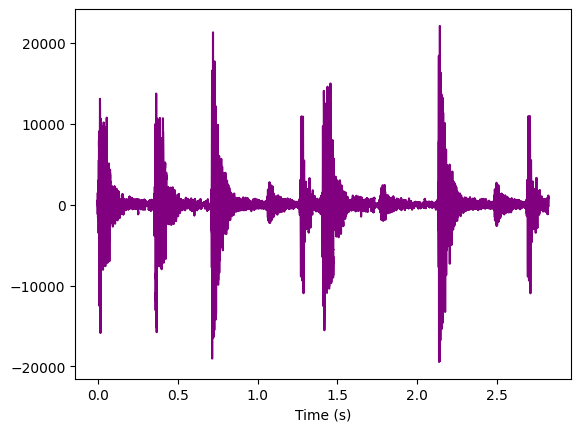

In [138]:
asegment = AudioSegment.from_wav(f)
asegment = asegment.set_channels(1)
asegment.export("mono.wav",format="wav")

s,a = wavfile.read("mono.wav")
print('Sampling Rate:',s)
print('Audio Shape:',np.shape(a))

duration = len(data)/samplerate
time = np.arange(0,duration,1/samplerate) #time vector

na = data.shape[0]
la = na / s
t = np.linspace(0,la,na)
plt.plot(t,a,'k-',color='purple')
plt.xlabel('Time (s)')
plt.show()

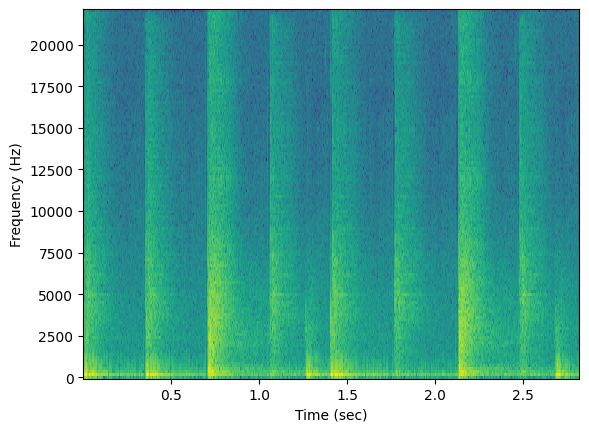

In [139]:
adata = data[:, 0]
s = samplerate
fr, tm, spgram = signal.spectrogram(adata,s)
lspg = np.log(spgram)
plt.pcolormesh(tm,fr,lspg,shading='auto')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.show()

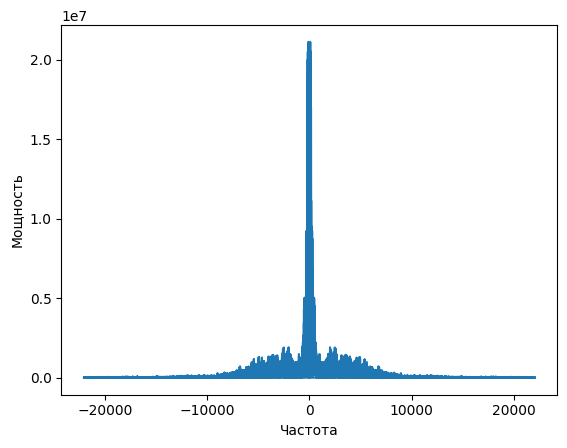

In [140]:
from scipy.fft import fft, fftfreq
# число точек в normalized_tone
N = int(samplerate * duration)
yf = fft(data[:, 0])
xf = fftfreq(N, 1 / samplerate)
plt.plot(xf, np.abs(yf))
plt.xlabel('Частота')
plt.ylabel('Мощность')
plt.show()

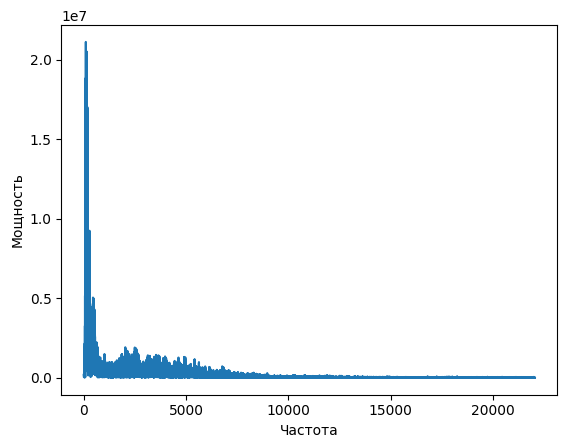

In [141]:
from scipy.fft import rfft, rfftfreq
# число точек в normalized_tone
rN = int(samplerate * duration)
ryf = rfft(data[:, 0])
rxf = rfftfreq(rN, 1 / samplerate)
plt.plot(rxf, np.abs(ryf))
plt.xlabel('Частота')
plt.ylabel('Мощность')
plt.show()

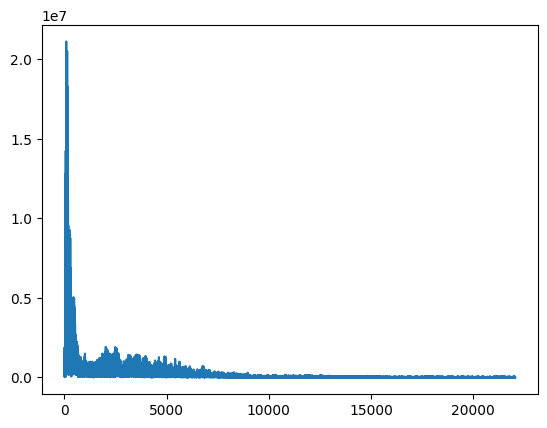

In [142]:
# Максимальная частота составляет половину частоты дискретизации
points_per_freq = len(rxf) / (samplerate / 2)
# Наша целевая частота
target_idx = int(points_per_freq * 4998.663426488456)
target_idx1 = int(points_per_freq * 10000)

ryf[target_idx-2:target_idx+2] = 0
plt.plot(rxf, np.abs(ryf))
plt.show()

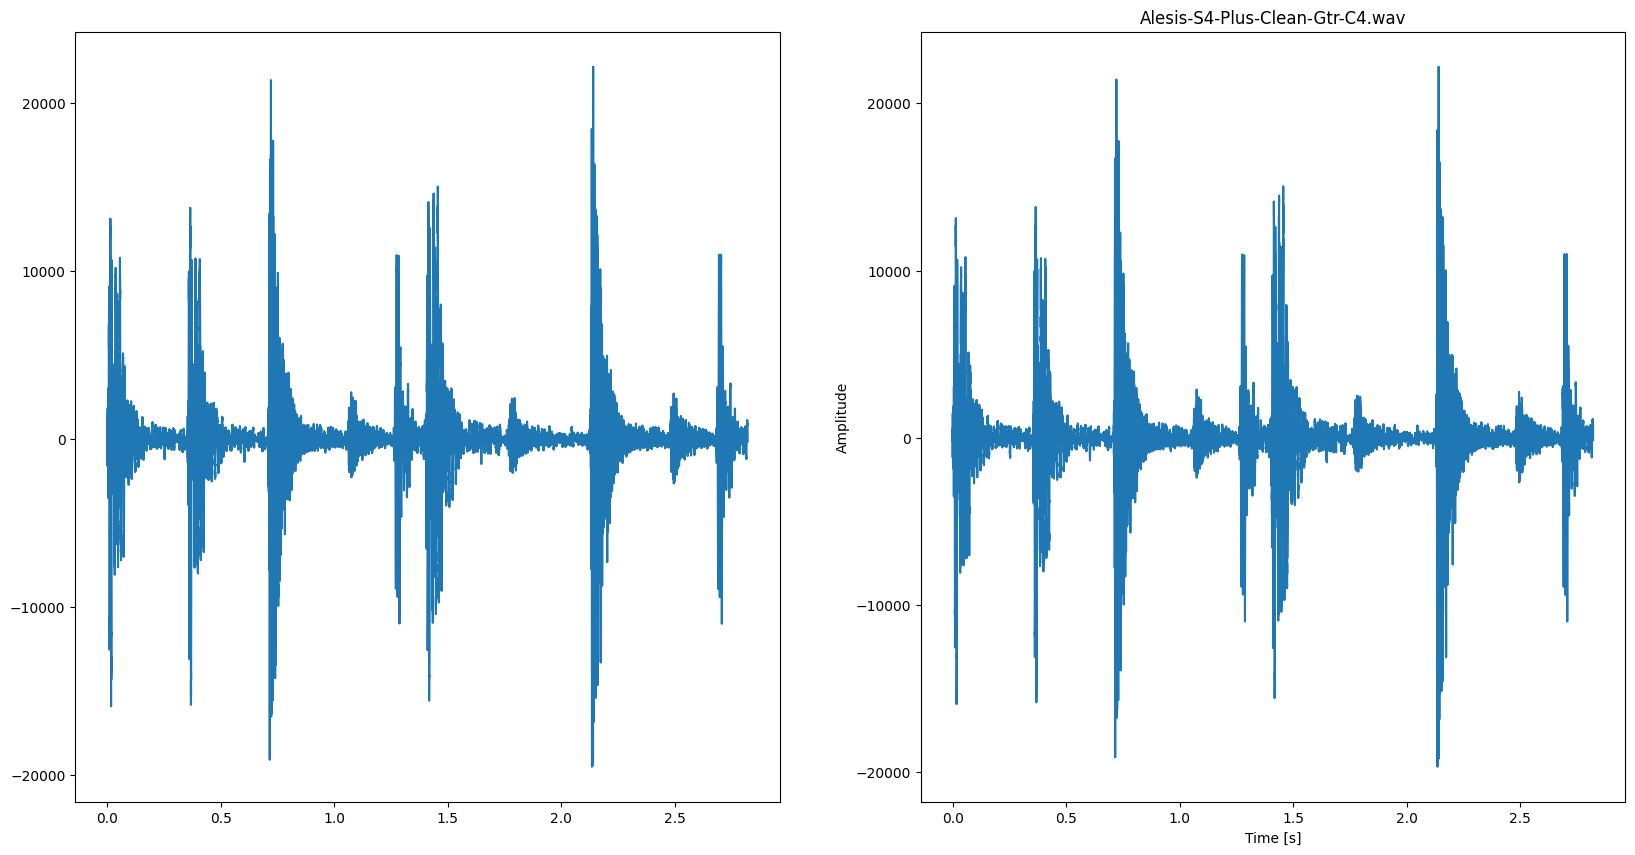

In [143]:
from scipy.fft import irfft

new_sig = irfft(ryf)

fig, ax = plt.subplots(nrows= 1 , ncols= 2, figsize=(20, 10) )

ax[0].plot(time, data[:, 0])
ax[1].plot(time[:len(time) - 1], new_sig)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Alesis-S4-Plus-Clean-Gtr-C4.wav')
plt.show()

In [144]:
# слушаем, что получилось
sd.play(data[:, 0], samplerate)
sd.wait()

sd.play(new_sig, samplerate)
sd.wait()

[Text(0.5, 1.0, 'MFCC')]

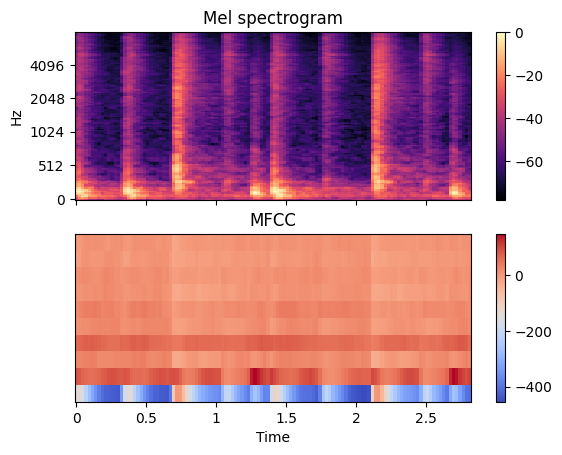

In [145]:
import librosa
samples, sample_rate = librosa.load("Ensoniq-ZR-76-03-Dope-85.wav")
y = samples
sr = sample_rate
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=10)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
x_axis='time', y_axis='mel', fmax=8000,
ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram')
ax[0].label_outer()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')

In [146]:
print(sample_rate)

22050


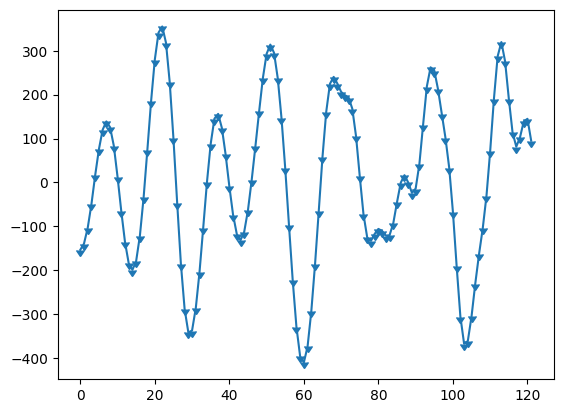

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.markers as markers

def B(b):
    return 1125 * np.log(1 + b / 700)

def B_1(b):
    return 700 * (np.exp(b / 1125) - 1)

def get_filter_points(fmin, fmax, mel_filter_num, wav_size, sample_rate=44100):    
    mels = np.linspace(B(fmin), B(fmax), num=mel_filter_num + 2)
    freqs = B_1(mels)
    
    return np.round((wav_size + 1) / sample_rate * freqs).astype(int)

def H_k_m(k,m, filter_points):
    h_k_m = 0
    if filter_points[m - 1] <= k < filter_points[m]:
        h_k_m = (k - filter_points[m - 1]) / (filter_points[m] - filter_points[m - 1])
    elif filter_points[m] <= k <= filter_points[m + 1]:
        h_k_m = (filter_points[m + 1] - k) / (filter_points[m + 1] - filter_points[m])
    return h_k_m

def S(M, N, filter_points, F_samples):
    res = []
    for m in range(1, M + 1):
        S_m = 0
        for k in range(N):
            S_m += (F_samples[k] ** 2) * H_k_m(k, m, filter_points)
        res.append(S_m)
    return res

def C(M, S):
    res = []
    for n in range(M):
        c_n = 0
        for m in range(M):
            c_n += S[m] * np.cos(np.pi * n * (m + 1 / 2) / M)
        res.append(c_n / 1000)
    return res

F_samples = np.fft.fft(samples)
M = 122
N = len(samples)

filters_points = get_filter_points(0, sample_rate / 2, M, N)

res_S = S(M,N,filters_points,F_samples)

res_C = C(M, res_S)

plt.plot(res_C, marker=markers.CARETDOWNBASE)



In [149]:
print(F_samples)

[ 1.58733205+5.32907052e-15j  2.45161653-5.30438120e-01j
  0.53363886-3.32147158e+00j ... -2.02139486+2.42698425e+00j
  0.53363886+3.32147158e+00j  2.45161653+5.30438120e-01j]
